In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!curl -L https://anaconda.org/conda-forge/gudhi/3.1.1/download/linux-64/gudhi-3.1.1-py36hd3ef239_1.tar.bz2 | tar xj
!mv lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import gudhi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3753    0  3753    0     0  14056      0 --:--:-- --:--:-- --:--:-- 14109
100 3217k  100 3217k    0     0  2430k      0  0:00:01  0:00:01 --:--:-- 3452k


# Load Dataset

In [ ]:
!pip install kaggle
api_token = {"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}
import json
import zipfile
import os
!mkdir /root/.kaggle
!echo '{"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}' > /root/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

data=pd.read_csv('mitbih_train.csv', header=None)

X = data[data.columns.values[:-1]]
y = data[data.columns.values[-1]]

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
 82% 81.0M/98.8M [00:02<00:00, 25.9MB/s]
100% 98.8M/98.8M [00:02<00:00, 35.5MB/s]
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


# Functions

In [ ]:
def getPersistence(vec, num_points=100, clean=True):
  """
  This transforms the 1D time series vec into a persistence diagram.
  """
  simplex_up = gudhi.SimplexTree()
  simplex_dw = gudhi.SimplexTree()
  # Fullfill the simplexes
  for i in np.arange(len(vec)): 
    simplex_up.insert([i], filtration=vec[i])
    simplex_dw.insert([i], filtration=-vec[i])
  for i in np.arange(len(vec)-1): 
    simplex_up.insert([i, i+1], filtration=vec[i])
    simplex_dw.insert([i, i+1], filtration=-vec[i])
  # Initialize the filtrations
  simplex_up.initialize_filtration()
  simplex_dw.initialize_filtration()


  dig_up = simplex_up.persistence()
  dig_dw = simplex_dw.persistence()

  if clean:
    dig_up = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_up if ele[1][1] < np.inf])
    dig_dw = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_dw if ele[1][1] < np.inf])

  return dig_up, dig_dw, simplex_up, simplex_dw

In [ ]:
def to_betti(vec, num_points=100):
  """
  This transforms the 1D time series vec into a betti curve with 100 points.
  No down simplex
  """
  dig_up, dig_dw, simplex_up, simplex_dw = getPersistence(vec, num_points, clean=True)

  mnu, mxu = np.min(dig_up), np.max(dig_up)
  #mnd, mxd = np.min(dig_dw), np.max(dig_dw)

  v,w = np.zeros(num_points), np.zeros(num_points)

  def functionize(val, descriptor):
    def dirichlet(x):
      return 1 if (x > descriptor[0]) and (x < descriptor[1]) else 0

    return np.vectorize(dirichlet)(val)

  val_up = np.linspace(mnu, mxu, num=num_points)
  #val_dw = np.linspace(mnd, mxd, num=num_points)

  for ele in dig_up: v += functionize(val_up, ele)
  #for ele in dig_dw: w += functionize(val_dw, ele)

  #return np.hstack([v, w])
  return v

In [ ]:
# http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/Tuto-Part4.html
# http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/persistence_graphical_tools_Bertrand.py
def landscapes_approx(diag_dim,x_min,x_max,nb_steps,nb_landscapes):
  """
  Returns nb_landscapes. Same as gudhi implementation
  """
  landscape = np.zeros((nb_landscapes,nb_steps))
  step = (x_max - x_min) / nb_steps
  #Warning: naive and not the best way to proceed!!!!!
  for i in range(nb_steps):
    x = x_min + i * step
    event_list = []
    for pair in diag_dim:
      b = pair[0]
      d = pair[1]
      if (b <= x) and (x<= d):
        if x >= (d+b)/2. :
          event_list.append((d-x))
        else:
          event_list.append((x-b))
    event_list.sort(reverse=True)
    event_list = np.asarray(event_list)
    for j in range(nb_landscapes):
      if(j<len(event_list)):
        landscape[j,i]=event_list[j]
        
  return landscape

In [ ]:
def confidence_interval(mu, lambdas, alpha=0.05, B=2000):
  n = lambdas.shape[0]

  thetas = np.zeros(B)

  for j in tqdm(range(B)):
    zetas = np.random.normal(size=(1,n))
    thetas[j] = np.max(np.abs(np.dot(zetas, lambdas-mu))/np.sqrt(n))

  zz = np.linspace(thetas.min(), thetas.max(), num=1000)
  Z_alpha = np.zeros(1000)
  for i, z in enumerate(zz):
    Z_alpha[i] = np.sum(thetas<z)/B

  idx = np.argmin(Z_alpha<=alpha)
  Z_alpha = zz[idx]

  lower = mu - Z_alpha/np.sqrt(n)
  upper = mu + Z_alpha/np.sqrt(n)

  return lower, upper

# Normalize area of landscapes

Although it is not necessary to perform Topological Data Analysis (and, in fact, it is never considered in the papers regardint the matter) we decided to normalize the area under the landscapes to force the algorithms to focus more on the morphological shape rather than on the actual values. Machine Learning -and Deep learning, specifically- algorithms tend to give bad results if the values are not normalize. With this trick, then, all landscapes seem be normalized for the algorithm, and so all landscapes will be considered the same.

For that part of the analysis, we decided to analyze the second landscape. The first landscape always represents the infinite ray of the barcode, i.e., it always has the same shape. The values in which this shape is represented may vary, but if we want to rely solely on the shape, it is better to select another landscape.

Lower levels of landscapes tend to have more important information, i.e., information about the highly perdurable homology classes. For that reason, we decided to use the second landscape and not another level any further.

In [ ]:
nbld = 2 # number of Landscapes 
resolution = 500
length_max = 1
length_min = 0
ld_dim = 0 # landscape dim

persistence = [getPersistence(X.iloc[i].to_numpy(), num_points=100, clean=False) for i in tqdm(range(X.shape[0]))]
diag = [x[0] for x in persistence]

L = np.zeros((len(diag), resolution))
for i in tqdm(range(len(diag))):
  L[i,:] = np.array(landscapes_approx([x[1] for x in diag[i][1:]], length_min, length_max, resolution,nbld)[1])

In [ ]:
import sklearn.metrics
x = np.linspace(0,length_max, num=resolution)

for i in tqdm(range(len(diag))):
  auc = sklearn.metrics.auc(x, L[i,:])
  if np.abs(auc) > 1e-6:
    L[i,:] = L[i,:] / auc 

## Average Landscapes with normalized area

Here we can see the representative Average Landscape (with normalized area) for each class that is presented on the data set. 

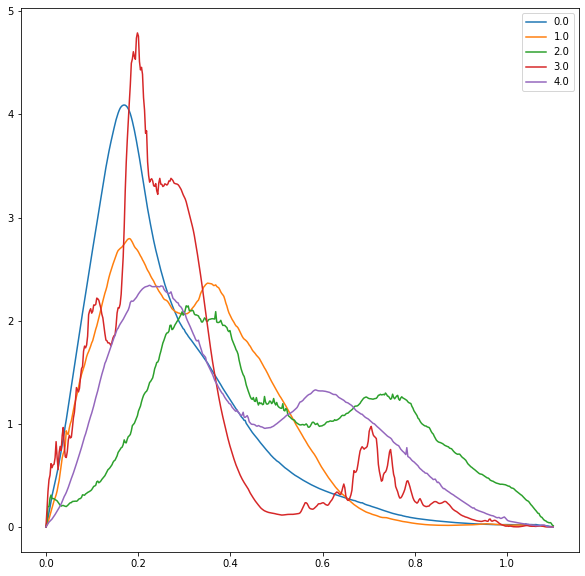

In [ ]:
L_avgs = np.zeros((y.unique().shape[0], resolution))
for idx,i in enumerate(y.unique()):
  L_avgs[idx] = np.mean(L[y==i, :], axis=0)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs.T)
plt.legend(y.unique())
plt.show()

## Confidence intervals with normalized area

We implemented a bootstrap algorithm that, given a set of landscapes for each class, computes the Average Landscape with some confidence intervals. The Average Landscape is a function that we are trying to estimate, so it makes sense to give such confidence intervals.

In [ ]:
lower = np.zeros((5,L_avgs.shape[1]))
upper = np.zeros((5,L_avgs.shape[1]))

for i in tqdm(range(5)):
  lower[i,:], upper[i,:] = confidence_interval(L_avgs[i,:], L[y==i,:], alpha=0.5)

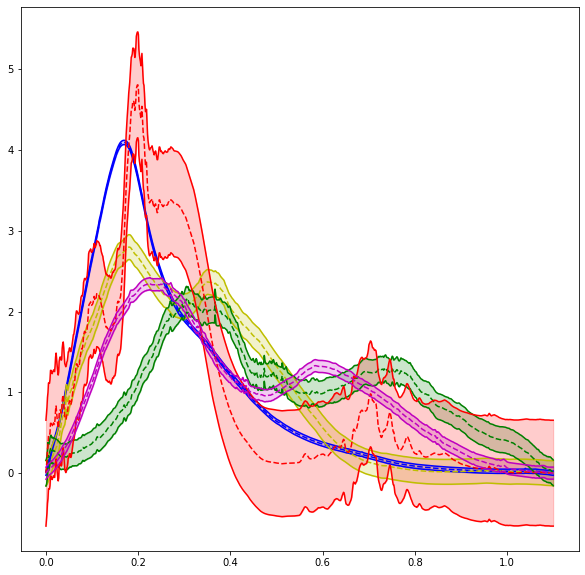

In [ ]:
plt.figure(figsize=(10,10))
colors = ['b', 'y', 'g', 'r', 'm']
for i in tqdm(range(5)):
  plt.fill_between(np.linspace(0,length_max * 1.1, num=resolution), lower[i,:], upper[i,:], color=colors[i], alpha=.2)
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs[i,:], colors[i]+'--')
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), lower[i,:], colors[i])
  plt.plot(np.linspace(0,length_max * 1.1, num=resolution), upper[i,:], colors[i])

plt.show()

## Distances with normalized area

In this section, we select 10 usual vector distances and for each one we proceed:

1. We compute a matrix distance between all the samples (each sample is represented as its second landscape). With that representation, we can evaluate how good is that distance at clustering landscapes.
2. We compute a matrix distance between the average landscapes. With this, we can know how good is that distance at distinguishing the possible class representatives.
3. For readability purposes, we produce a mean distance matrix between all samples. This means that, given two classes $i$ and $j$, we perform the mean of $d(l_i^n, l_j^m)$ where $l_i^n$ is a sample of class $i$ and $l_j^m$ is a sample of class $j$. In this way, we obtain a matrix similar to the one in point $1$, only this time it is easier to read. We expect the diagonal squares to be darker (this would mean that the distance between elements of the same class is low) and the other squares to be lighter (meaning that the distance between elements of different classes is higher). Our goal is to look for the distance that produces the best matrix distance. 

In [ ]:
indexes = [np.where(y==i)[0][-1] for i in np.unique(y)]
indexes

[72470, 74693, 80481, 81122, 87553]

### Infinit distance

In [ ]:
def dist_inf(f1, f2):
  return np.max(np.abs(f1-f2))

def dist2(L, mu):
  dist_matrix = np.zeros((L.shape[0]))
  for i,x in enumerate(L):
    dist_matrix[i] = dist_inf(x,mu)
  return dist_matrix

0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


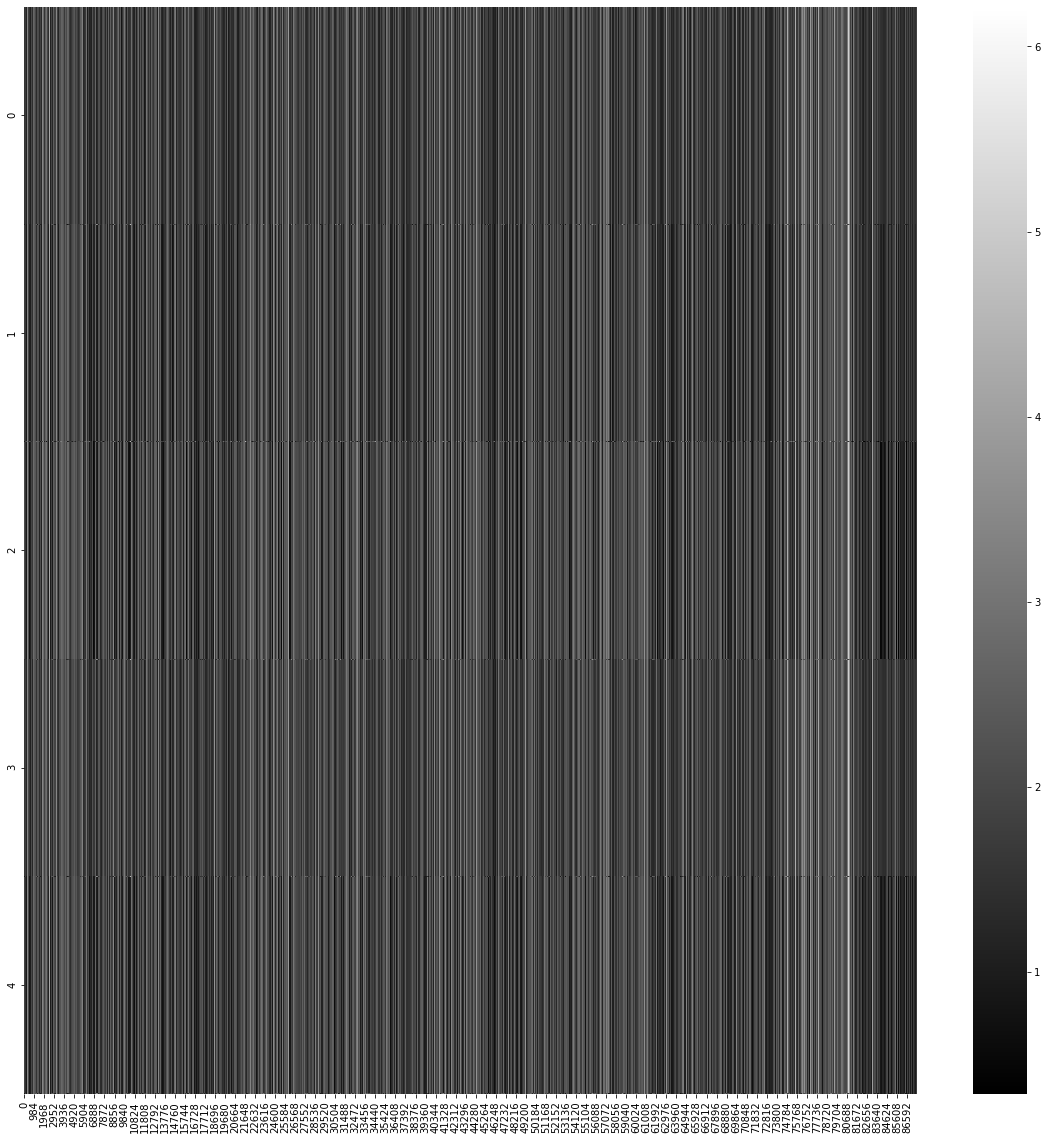

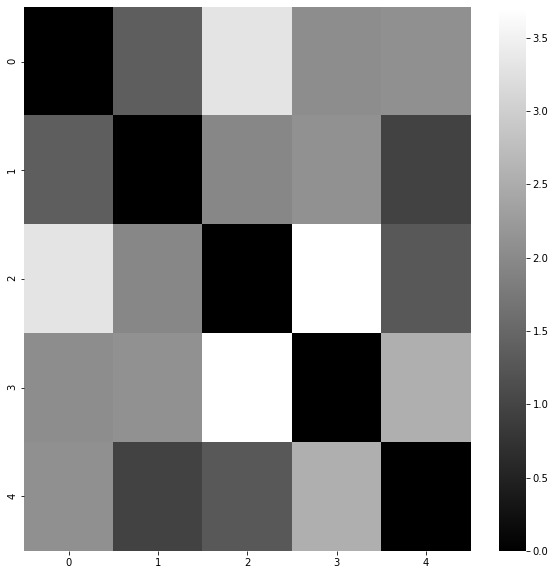

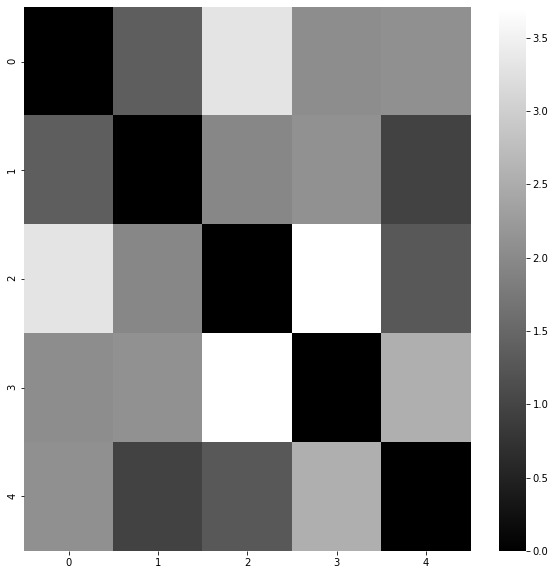

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in enumerate(y.unique()):
    mat[idx,:] = np.log(dist2(L, L_avgs[idx,:])+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = dist_inf(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      print(ii, indexes[i])
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

In [ ]:
import scipy

def dist_f(L, mu, dist):
  dist_matrix = np.zeros((L.shape[0]))
  for i,x in enumerate(L):
    dist_matrix[i] = dist(x,mu)
  return dist_matrix

### Wasserstein distance


0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


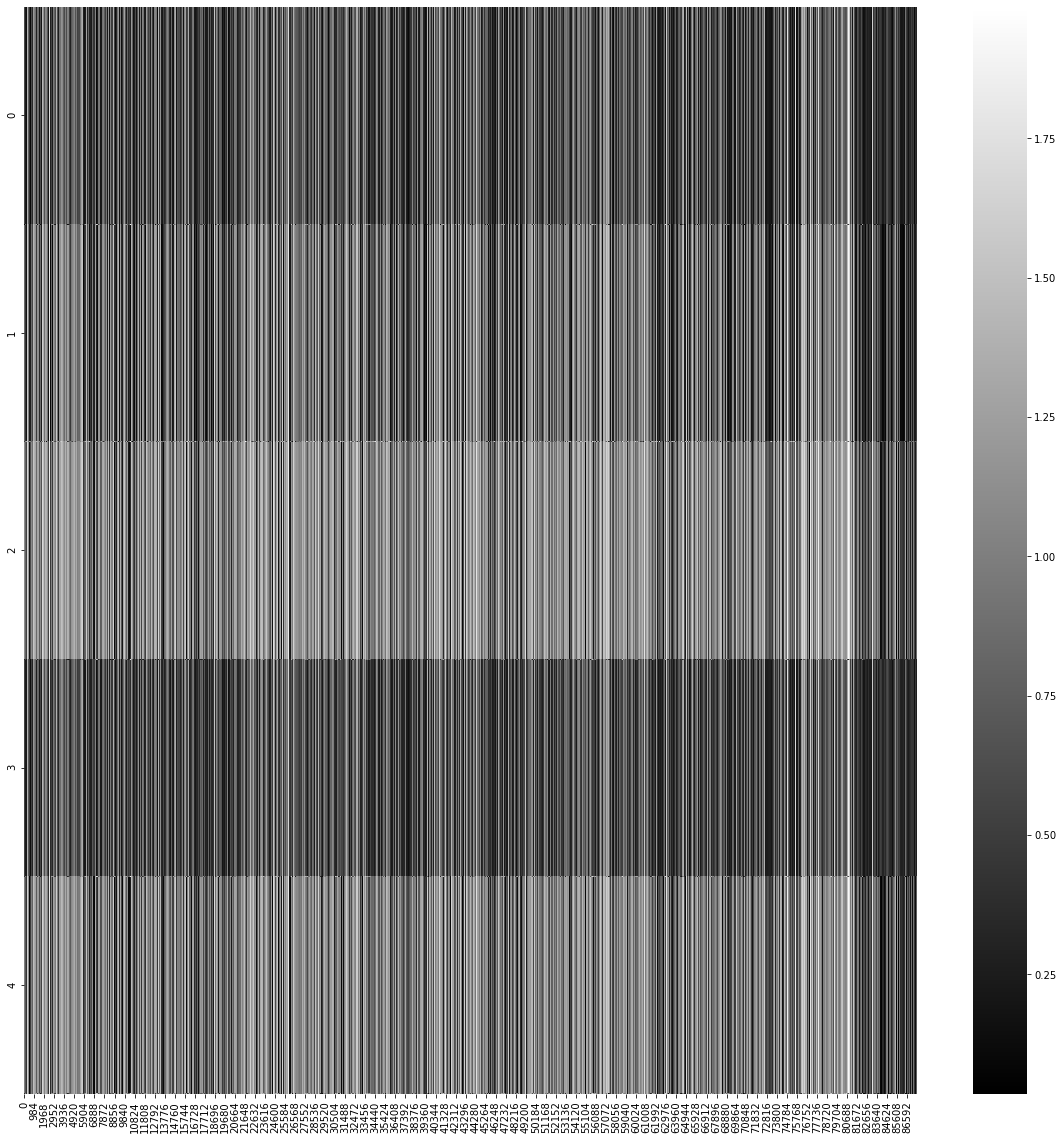

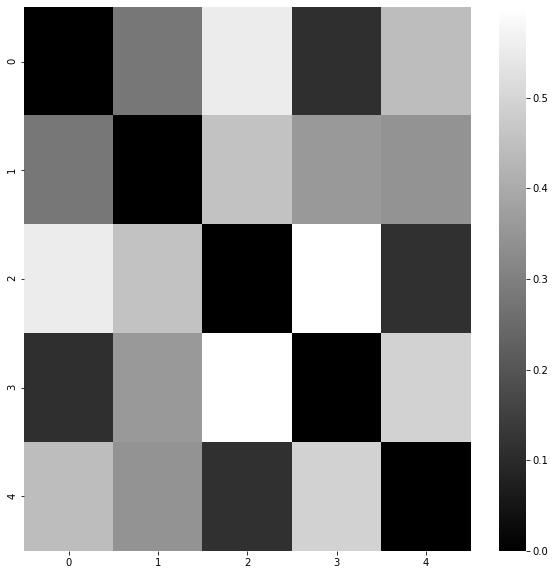

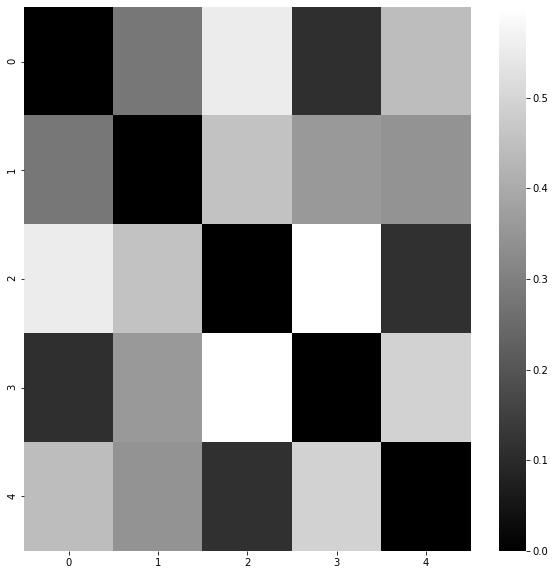

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = dist_f(L, L_avgs[idx,:], scipy.stats.wasserstein_distance)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.stats.wasserstein_distance(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Bray-Curtis distance


0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


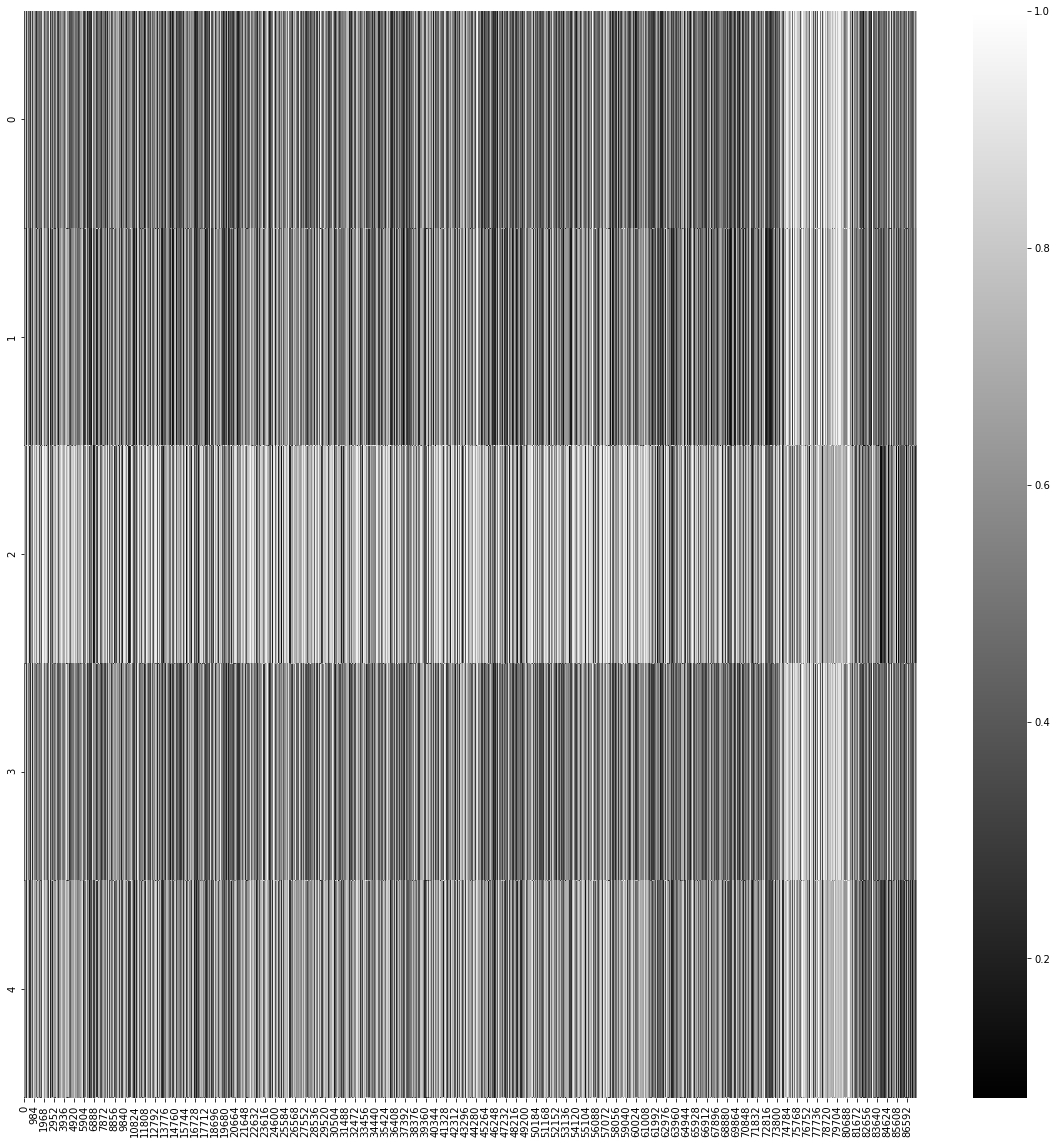

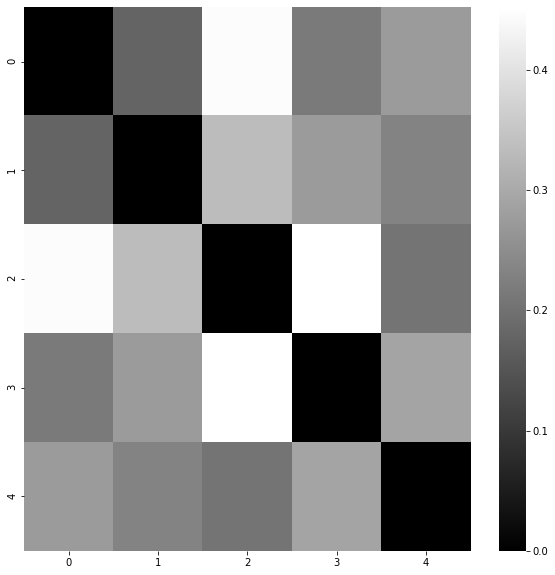

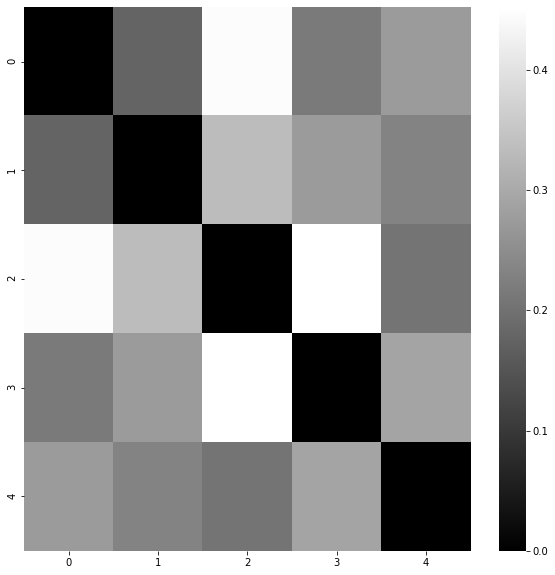

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = dist_f(L, L_avgs[idx,:], scipy.spatial.distance.braycurtis)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.braycurtis(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Canberra distance


0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


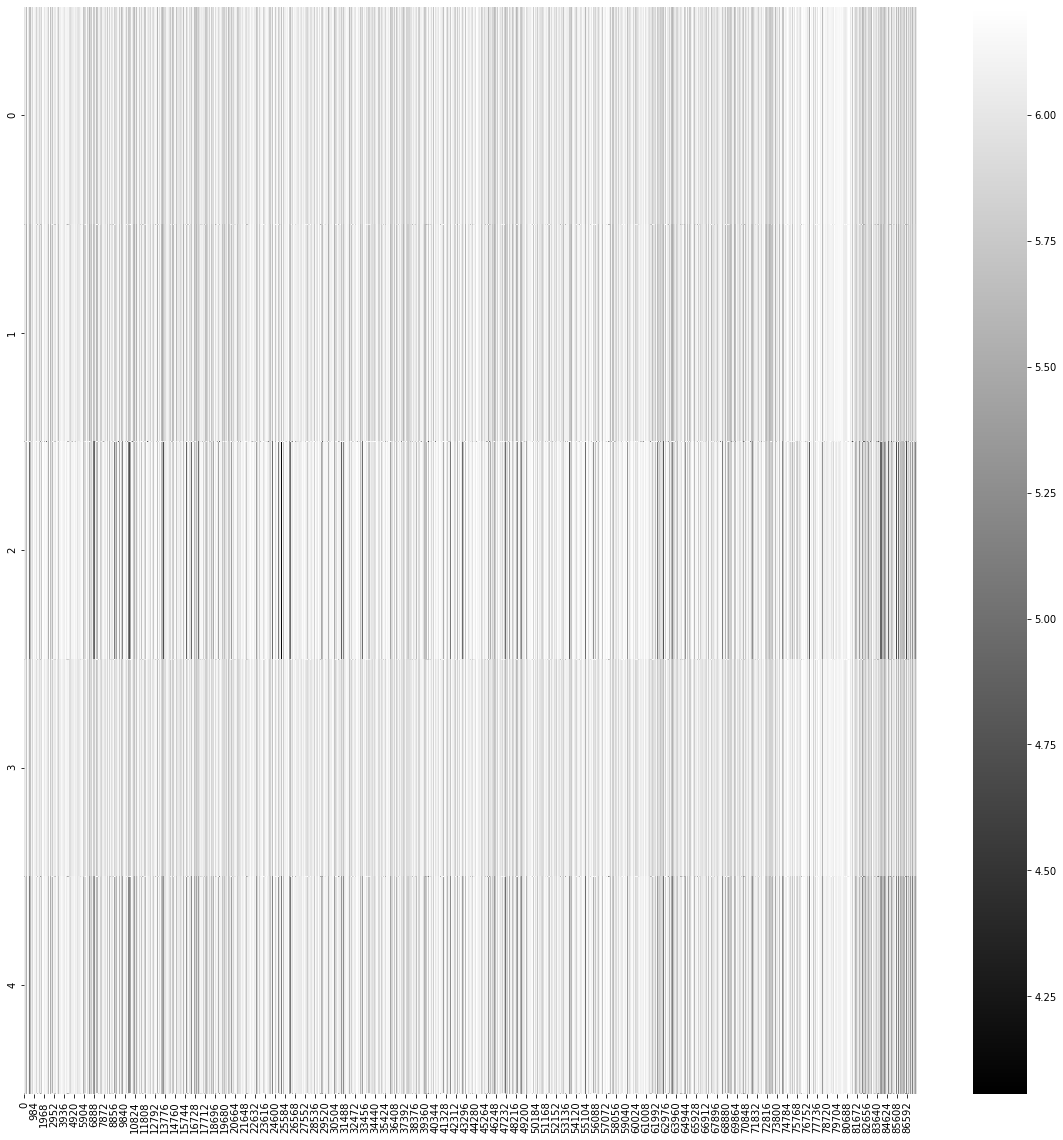

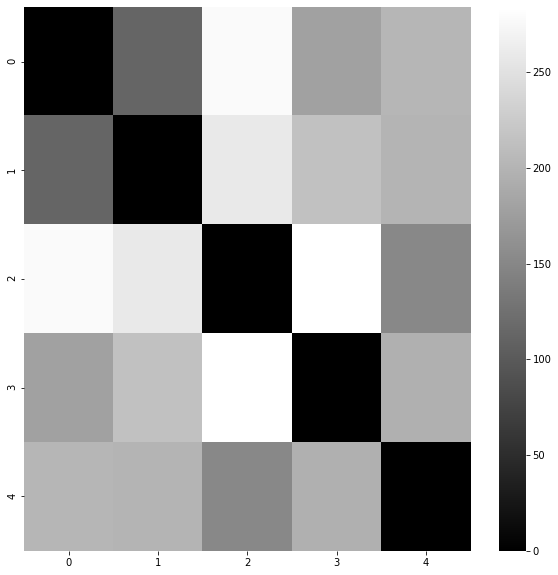

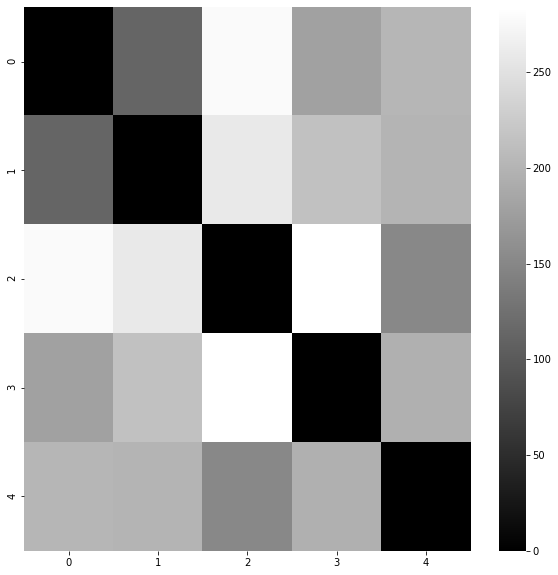

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.canberra)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.canberra(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Manhattan distance


0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


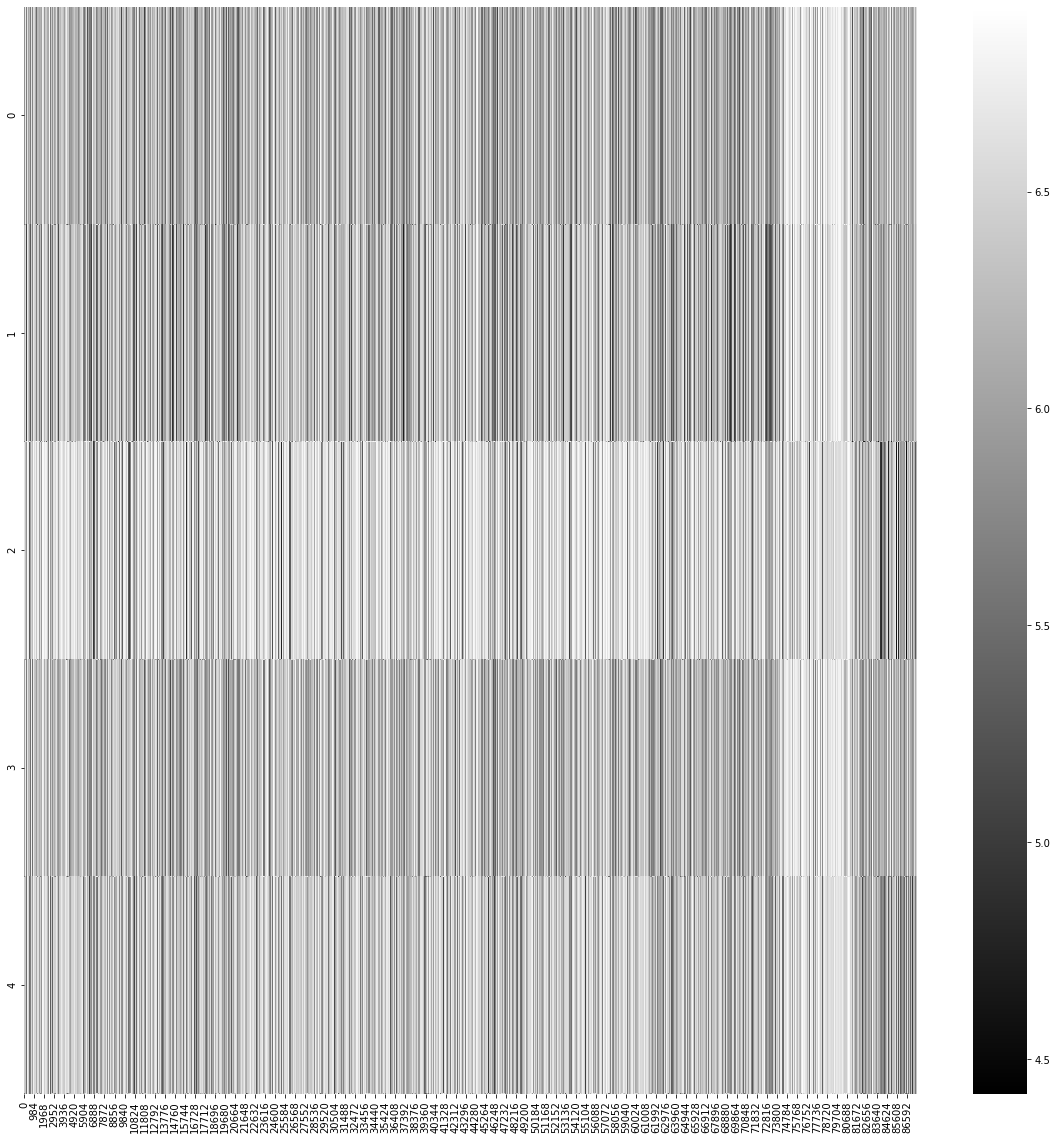

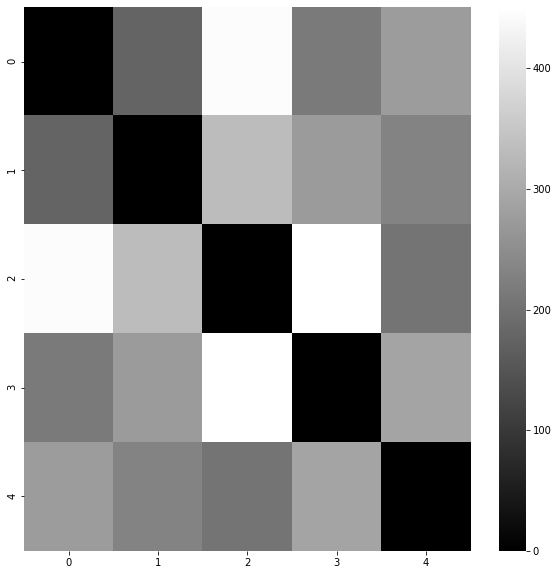

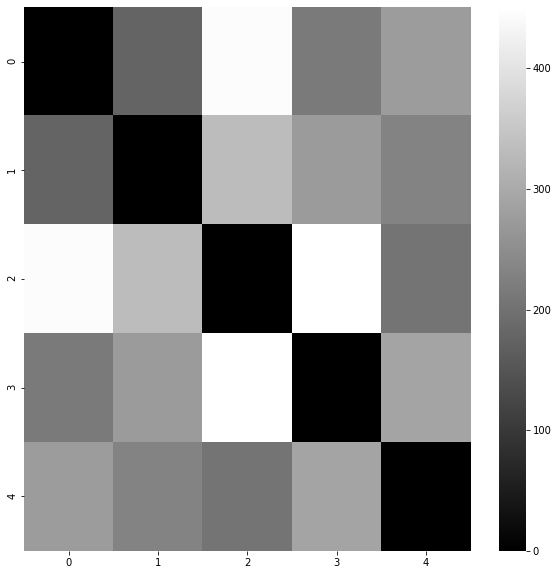

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.cityblock)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.cityblock(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Correlation distance 


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


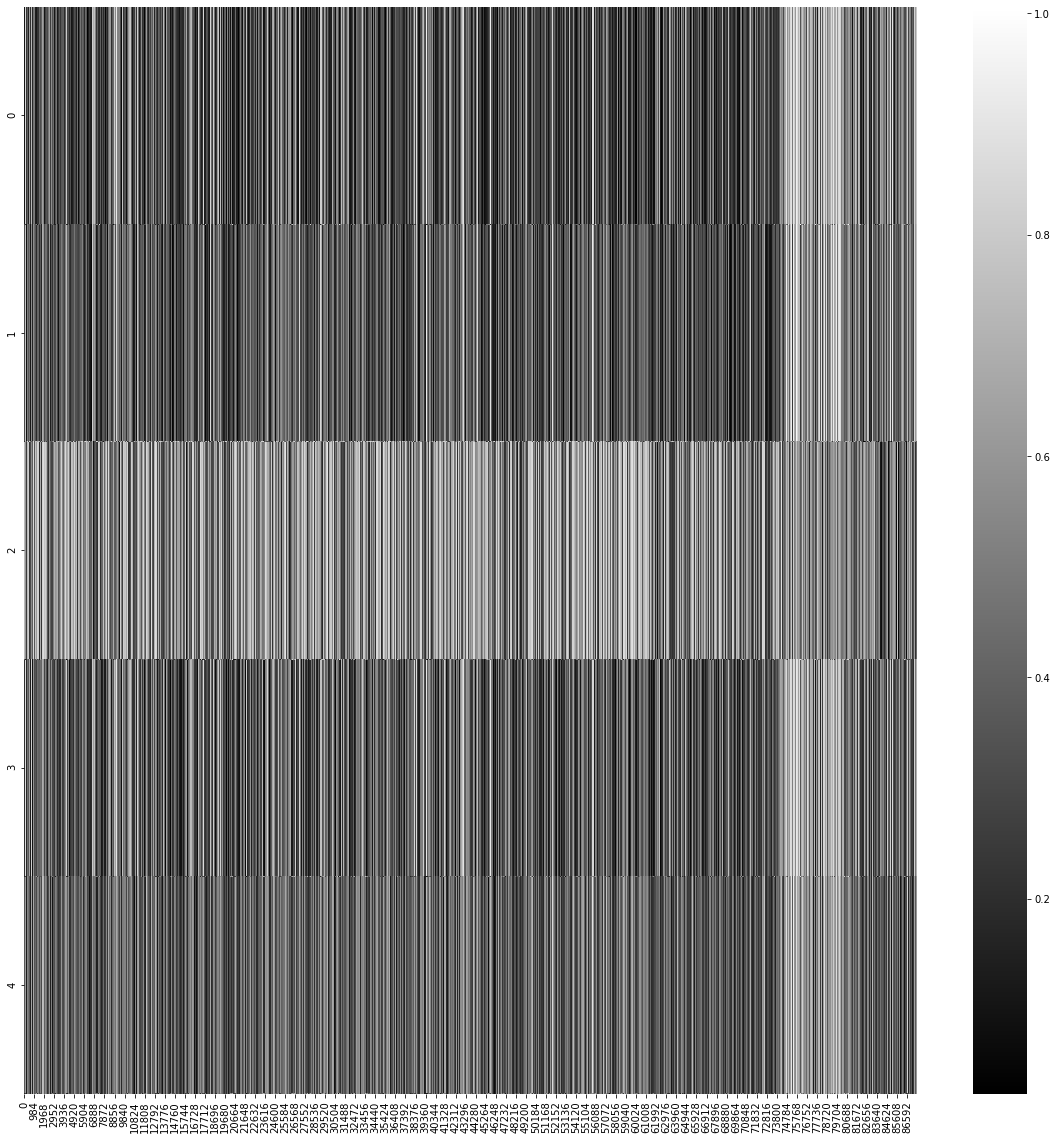

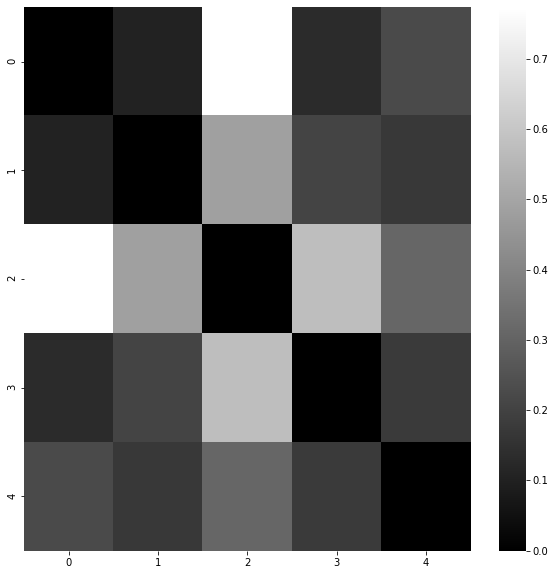

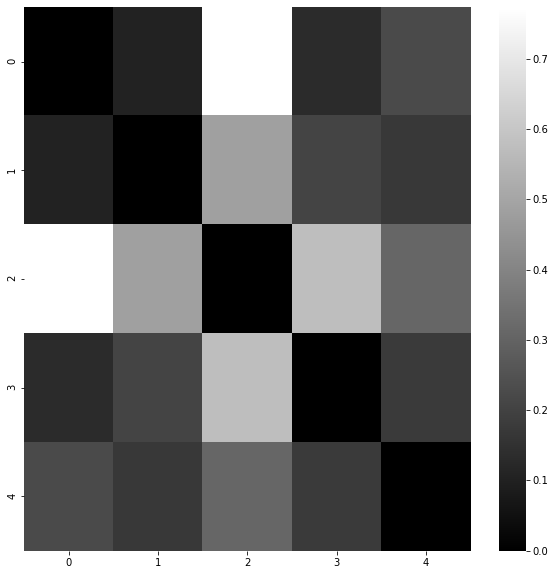

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.correlation)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.correlation(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Cosine distance

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


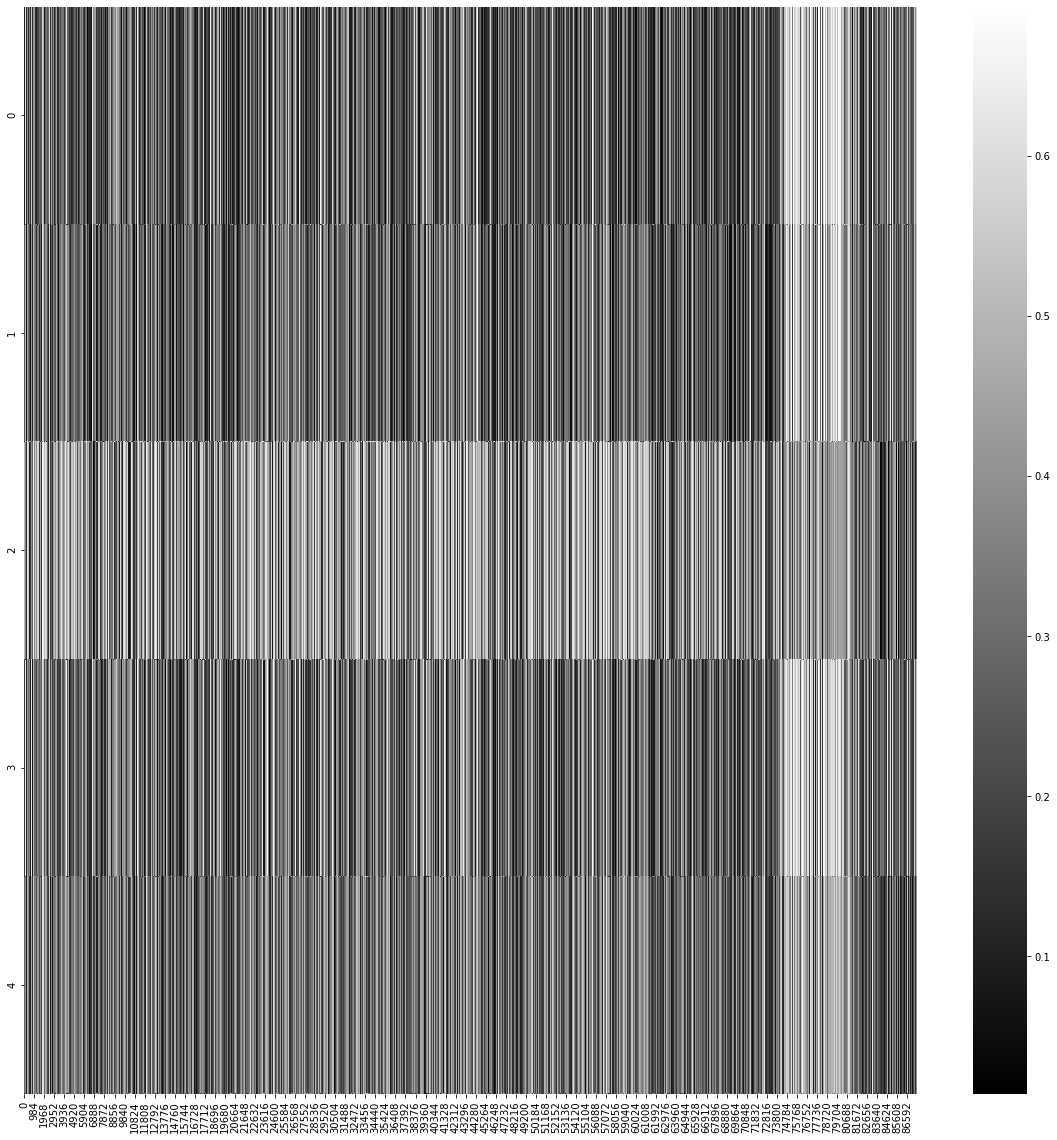

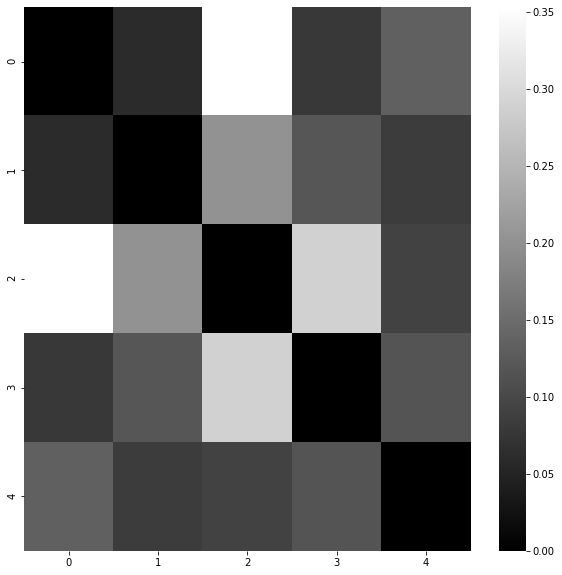

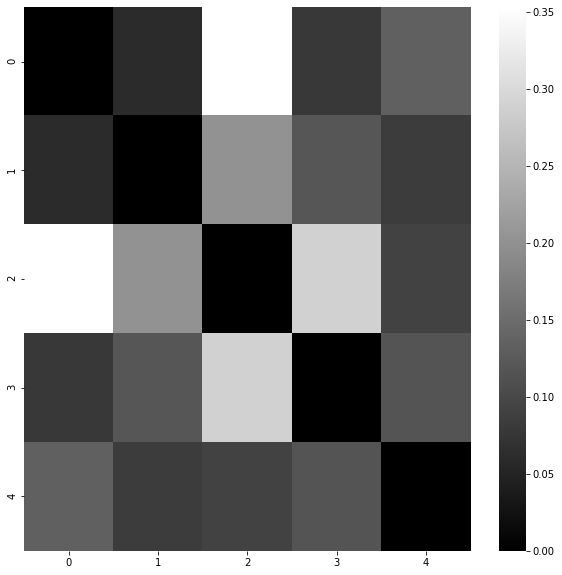

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.cosine)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.cosine(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Euclidean distance


0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


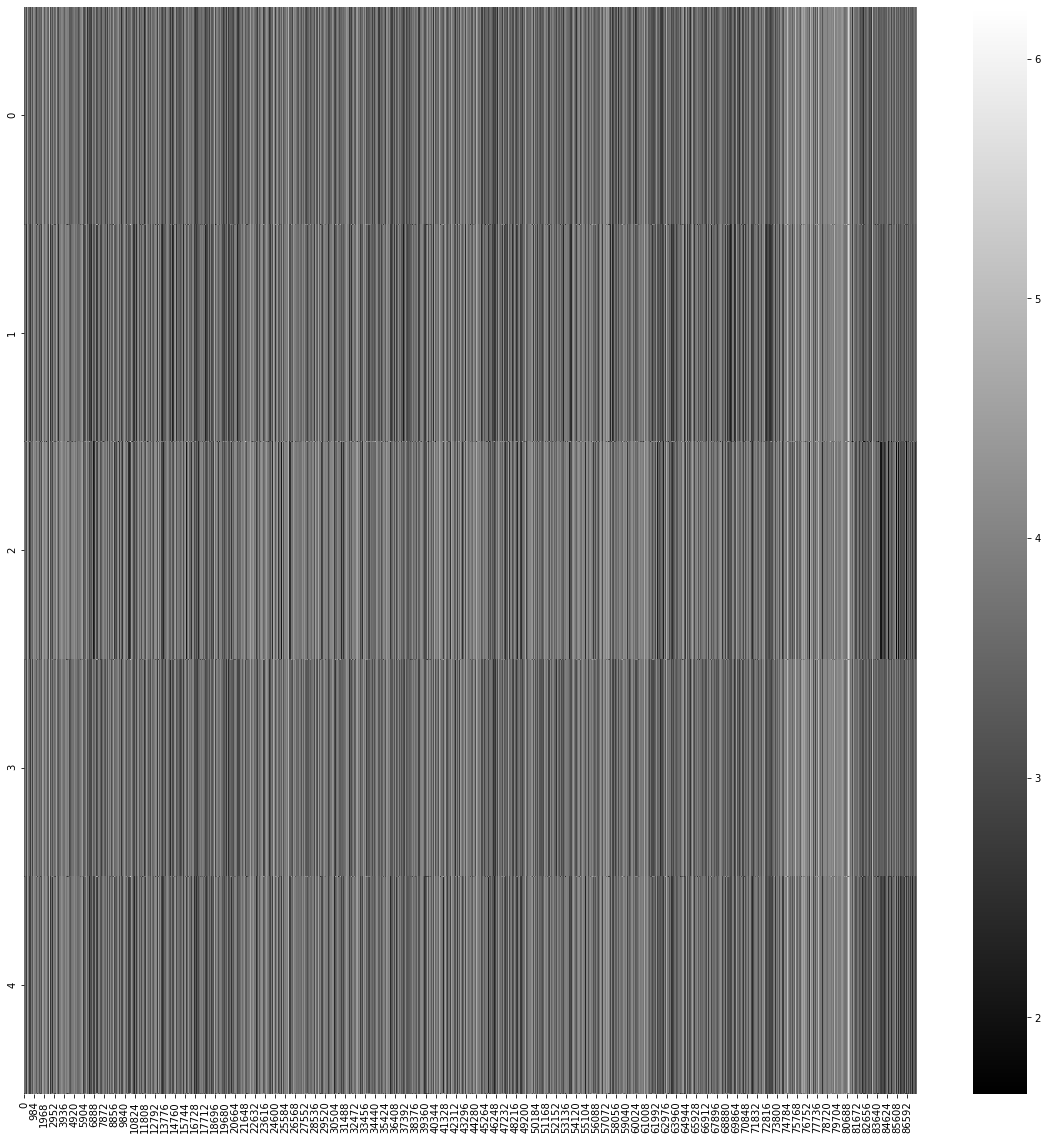

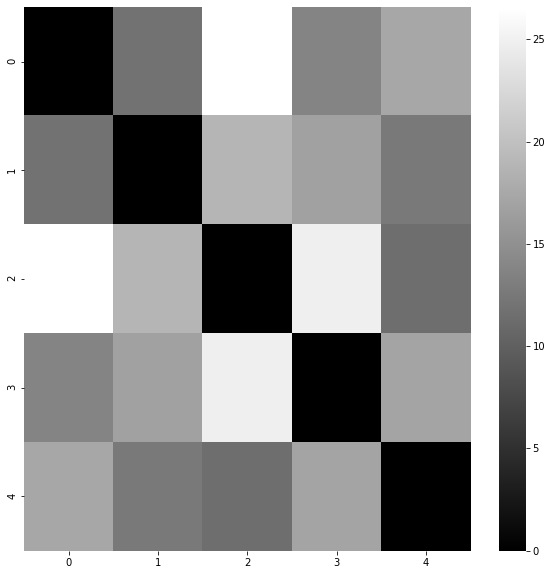

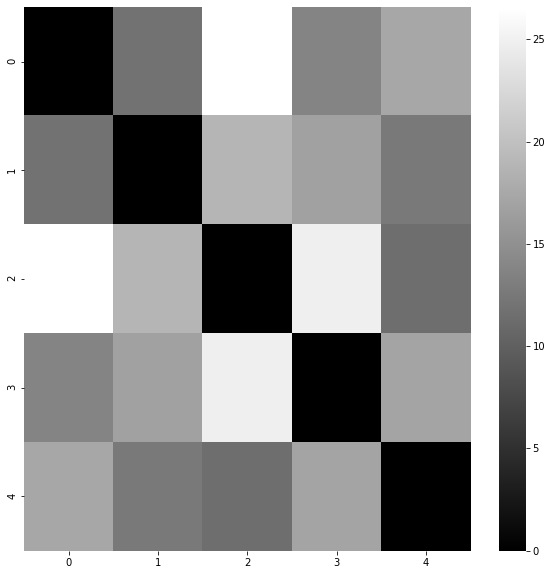

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.euclidean)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.euclidean(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Jensen-Shannon distance

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)



0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553
0 72470
72470 74693
74693 80481
80481 81122
81122 87553


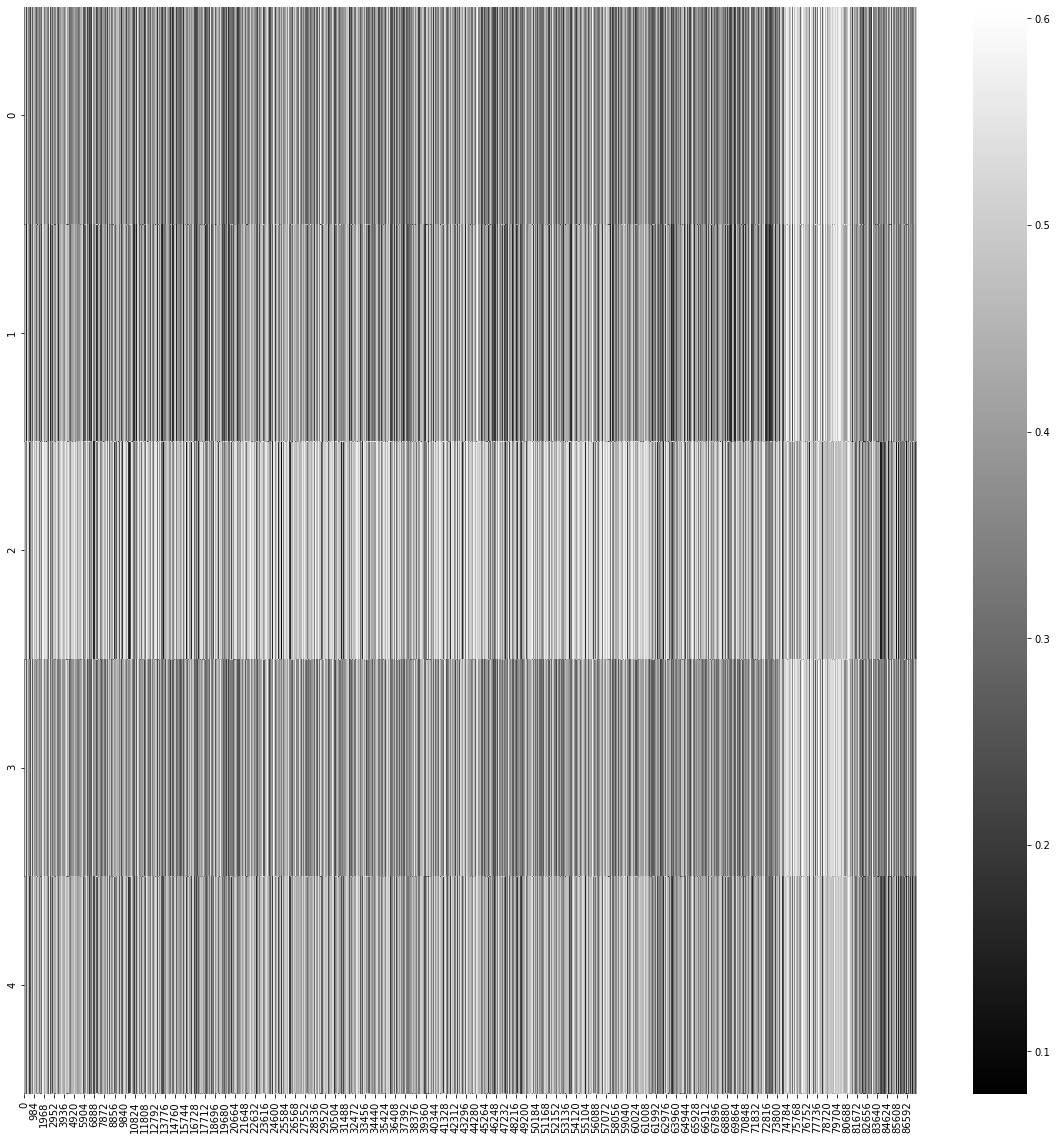

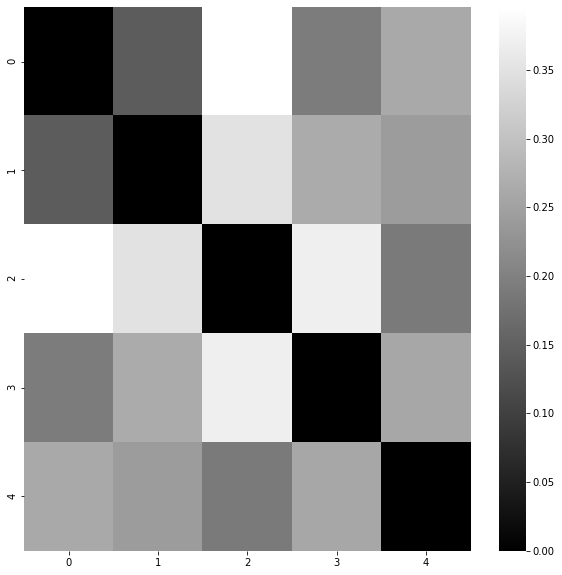

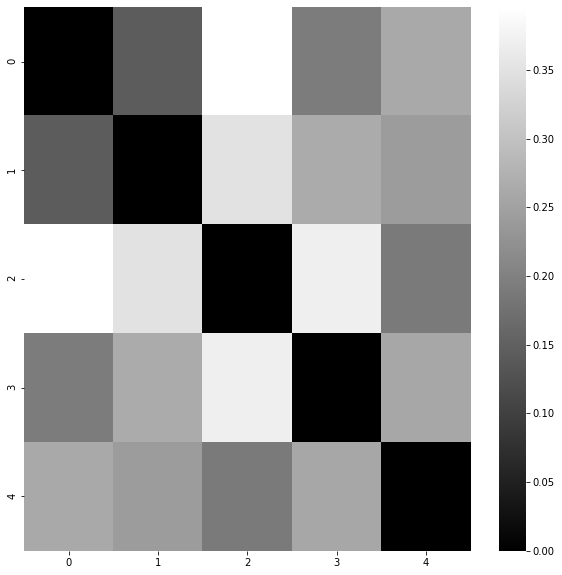

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.jensenshannon)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.jensenshannon(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

### Minkowski distance

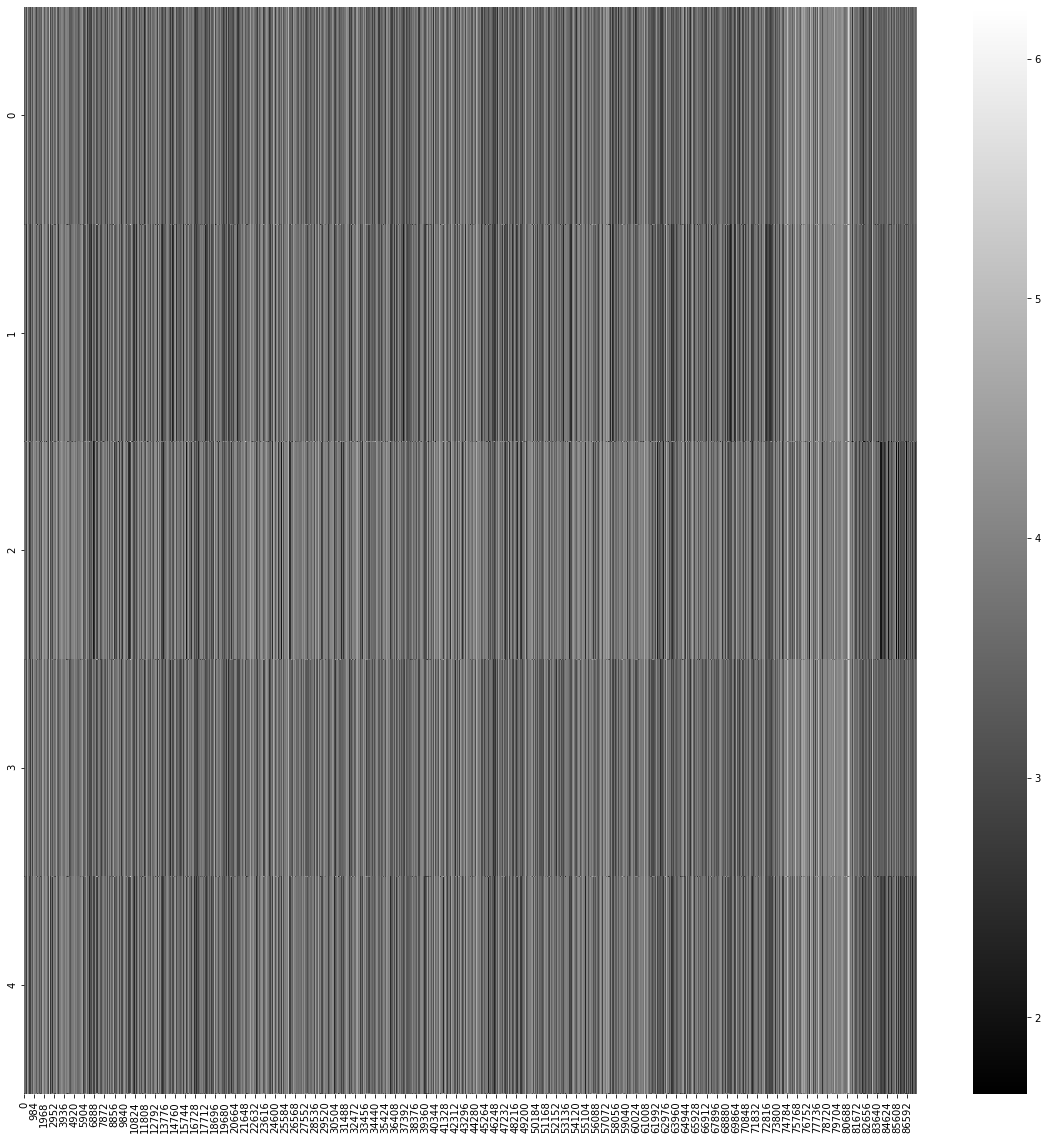

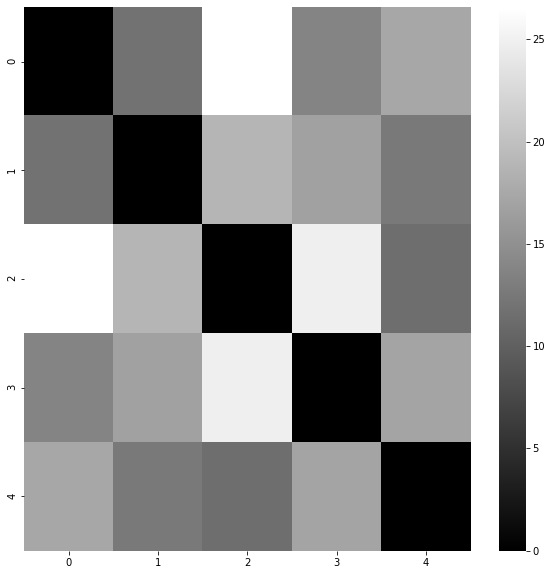

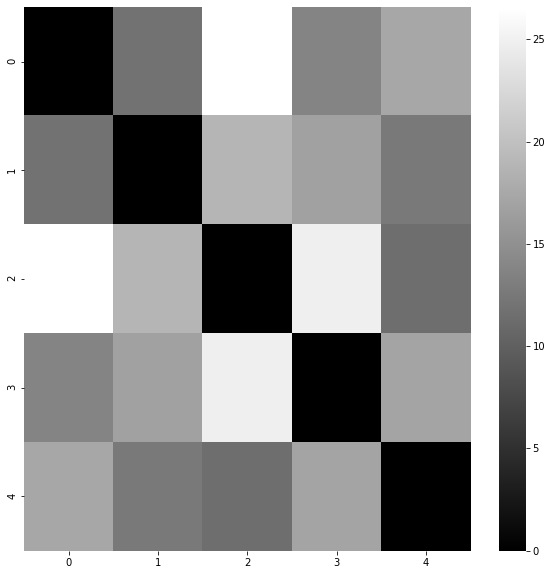

In [ ]:
mat = np.zeros((5, L.shape[0]))
for idx, i in tqdm(enumerate(y.unique())):
    mat[idx,:] = np.log(dist_f(L, L_avgs[idx,:], scipy.spatial.distance.minkowski)+1)

plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="gray")

dist_mat = np.zeros((5,5))

for i in range(5):
  for j in range(5):
    dist_mat[i,j] = scipy.spatial.distance.minkowski(L_avgs[i,:], L_avgs[j,:])

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

dist_mean_mat = np.zeros((5,5))

ii = 0
for j in range(5):
  for i in range(5):
      dist_mean_mat[i, j] = np.mean(mat[j, ii:indexes[i]])
      ii = indexes[i]
      if i == 4:
        ii = 0

plt.figure(figsize=(10,10))
sns.heatmap(dist_mat, cmap="gray")

# Test classification

In this section, we test if it would be possible to implement a simple classification algorithm. The algorithm is as follows:

1. First, we need to compute the average landscape for each class.
2. Then, for each sample that we want to classify, we need to compute its landscape classification.
3. We compute the distance between our sample and each average landscape.
4. The classified class is the one whose distance between the sample and the average landscape is lower.

We will check the results for those distances that we selected in the previous section.

In [ ]:
def predict(averages, sample, distance):
  best_dist = np.inf
  best_idx = -1
  for idx, av in enumerate(averages):
    d = distance(av, sample)
    if d < best_dist:
      best_dist = d
      best_idx = idx
  return best_idx


def predict_block(averages, samples, distance):
  y_pred = np.zeros(samples.shape[0])
  for j in range(samples.shape[0]):
    y_pred[j] = predict(averages, samples[j,:], distance)
  return y_pred

## Infinit distance

In [ ]:
accs = []

In [ ]:
y_pred = predict_block(L_avgs, L, dist_inf)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[0]

0.36977179797610615

## Wasserstein distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.stats.wasserstein_distance)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[1]

0.1274641935262809

## Bray-Curtis distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.braycurtis)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[2]

0.43181350937707014

## Canberra distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.canberra)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[3]

0.402186079448112

## Manhattan distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.cityblock)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[4]

0.4318706169906572

## Correlation distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.correlation)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[5]

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


0.4324302716038102

## Cosine distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.cosine)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[6]

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


0.43296708317152843

## Euclidean distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.euclidean)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[7]

0.42902665783402244

## Jensen-Shannon distnace

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.jensenshannon)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[8]

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


0.4328414464216369

## Minkowski distance

In [ ]:
y_pred = predict_block(L_avgs, L, scipy.spatial.distance.minkowski)
accs.append(sum(y_pred == y)/y_pred.shape[0])
accs[9]

0.42902665783402244

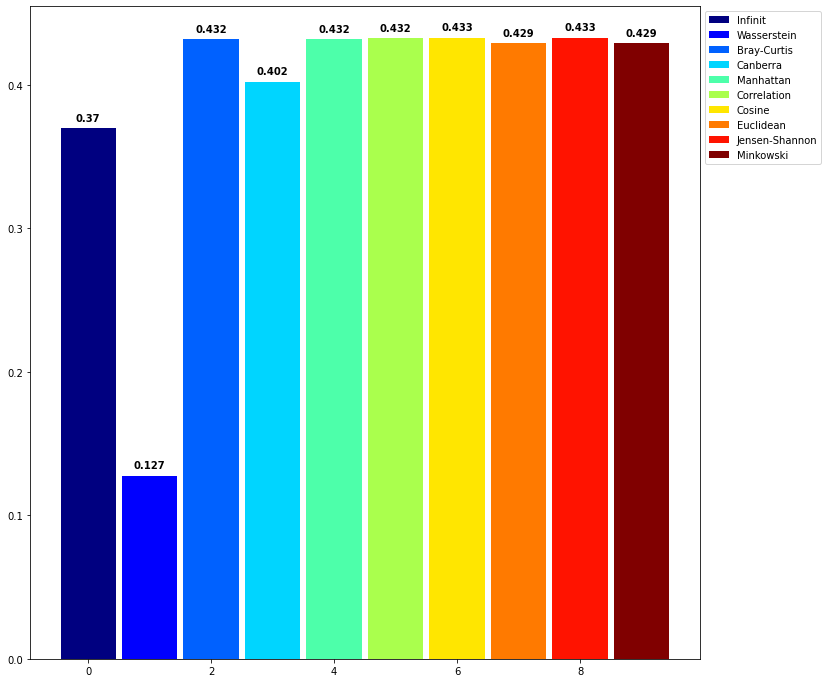

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(12,12))
colors = cm.jet(np.linspace(0,1,num=10))
for i in range(10):
    plt.bar(i, accs[i], width=0.9, color=colors[i])
    plt.text(i, accs[i]+0.005, str( np.round(accs[i],3)), fontweight='bold', horizontalalignment='center')
plt.legend(["Infinit", "Wasserstein", "Bray-Curtis", "Canberra", "Manhattan", "Correlation", "Cosine", "Euclidean", "Jensen-Shannon", "Minkowski"], bbox_to_anchor=(1, 1))
plt.show()

# Framework Train + Test classification

We realize that a simple algorithm for classification can be implemented, so we propose the full framework here.

The first thing we have to do is to separate in train + test, otherwise we would be computing the Average Landscape with samples that are supposed to not have been seen yet. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(L, y.to_numpy(), test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(70043, 500) (17511, 500)
(70043,) (17511,)


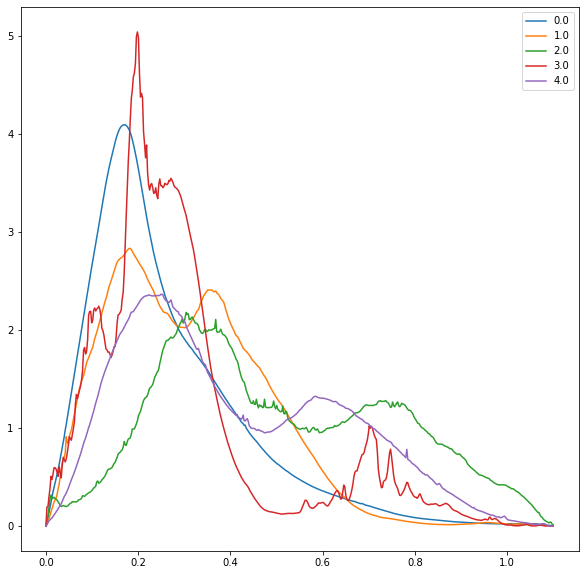

In [ ]:
L_avgs_train = np.zeros((np.unique(y_train).shape[0], resolution))
for idx,i in enumerate(np.unique(y)):
  L_avgs_train[idx] = np.mean(X_train[y_train==i, :], axis=0)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,length_max * 1.1, num=resolution), L_avgs_train.T)
plt.legend(y.unique())
plt.show()

## Functions

In [ ]:
def accuracy(pred, true):
  return sum(pred == true)/pred.shape[0]

def compute_accuracies(avgs, Ls, y_true):
  accs = []
  y_pred = predict_block(avgs, Ls, dist_inf)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.stats.wasserstein_distance)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.braycurtis)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.canberra)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.cityblock)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.correlation)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.cosine)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.euclidean)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.jensenshannon)
  accs.append(accuracy(y_pred, y_true))
  y_pred = predict_block(avgs, Ls, scipy.spatial.distance.minkowski)
  accs.append(accuracy(y_pred, y_true))
  
  return accs

def plot_results(accs):
  plt.figure(figsize=(12,12))
  colors = cm.jet(np.linspace(0,1,num=10))
  for i in range(10):
      plt.bar(i, accs[i], width=0.9, color=colors[i])
      plt.text(i, accs[i]+0.005, str( np.round(accs[i],3)), fontweight='bold', horizontalalignment='center')
  plt.legend(["Infinit", "Wasserstein", "Bray-Curtis", "Canberra", "Manhattan", "Correlation", "Cosine", "Euclidean", "Jensen-Shannon", "Minkowski"], bbox_to_anchor=(1, 1))
  plt.show()

## Compute accuracy train

We compute the results of our simple classifying algorithm. We test for each of the selected distances. Note that most of the distances have an accuracy arond $0.4$ which is better than a random prediction (would be around $0.2$). This means that this representation is not trivial and that it could be improved with a better distance (perhaps learnt through some Machine Learning algorithm).

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


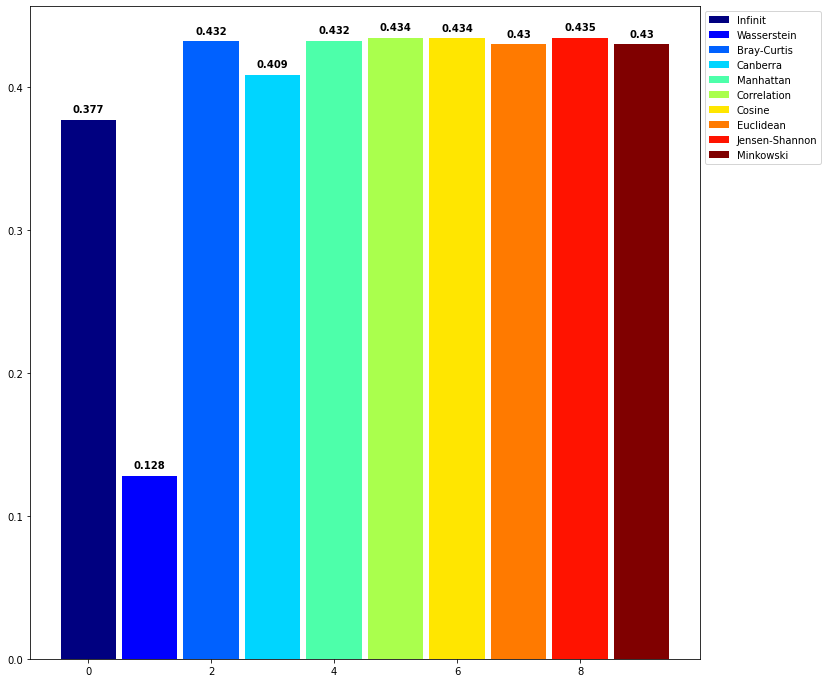

In [ ]:
accs = compute_accuracies(L_avgs_train, X_train, y_train)
plot_results(accs)

## Compute accuracy test

It is also curious to note how the accuracy between test and train is practically the same. This means that the geometrical component is consistent through all the data-set. It also means that probably we would not improve the Average landscape with more samples. 

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


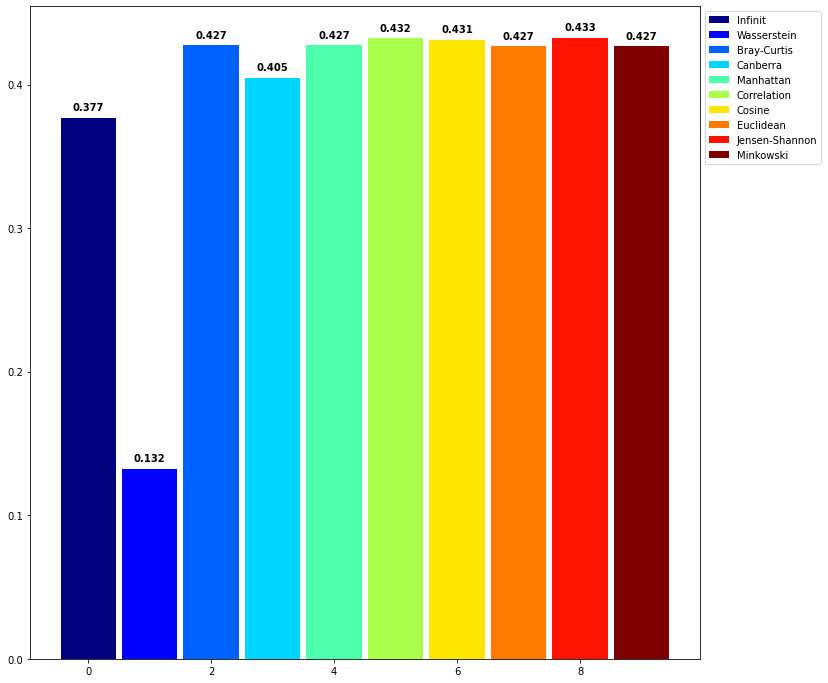

In [ ]:
accs = compute_accuracies(L_avgs_train, X_test, y_test)
plot_results(accs)

# Check errors

Finally, we give a snippet of code that checks the errors. Given a distance, we check all the missclassified samples and compare the wrong given class to the true class that should have been assigned. In this way, we can see which classes have very similar shapes and hence are confusing the algorithm.

In [ ]:
def plot_errors(avgs, samples, true, pred, N):
  idxs = np.where([true != pred])[1]
  idx = np.random.choice(idxs, N, replace=False)

  plt.figure(figsize=(15, 15))
  for i in range(N):
    ax = plt.subplot(N, 3, 3*i + 1)
    ax.plot(np.linspace(0,length_max * 1.1, num=resolution), samples[idx[i],:])
    ax.set_title("Landscape")
    ax = plt.subplot(N, 3, 3*i + 2)
    ax.plot(np.linspace(0,length_max * 1.1, num=resolution), avgs[int(true[idx[i]]),:])
    ax.set_title("True class: "+str(int(true[idx[i]])))
    ax = plt.subplot(N, 3, 3*i + 3)
    ax.plot(np.linspace(0,length_max * 1.1, num=resolution),avgs[int(pred[idx[i]]),:])
    ax.set_title("Predicted class: "+str(int(pred[idx[i]])))
  plt.show()

def statistic_errors(true, pred):
  idxs = np.where([true != pred])[1]
  true_errors = true[idxs]
  errs = []
  for i in range(5):
    errs.append(np.sum(true_errors == i)/true_errors.shape[0])

  return errs

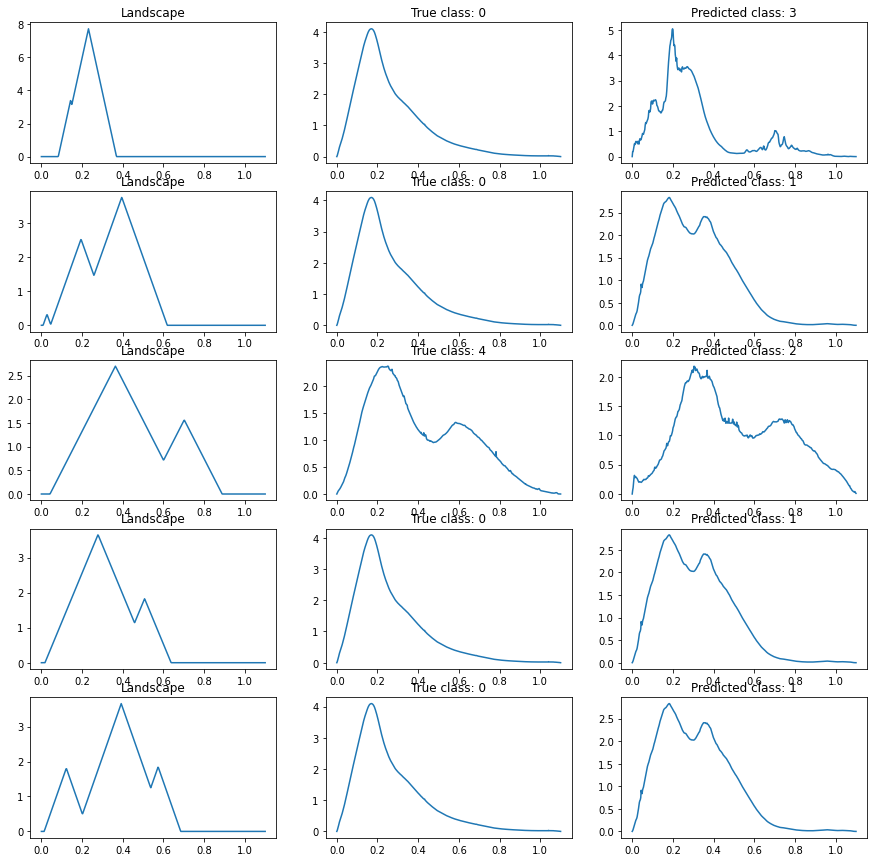

[0.8350489643599569, 0.027400005009141682, 0.04007313346858016, 0.006061061437122749, 0.09141683572519849]


In [ ]:
y_pred = predict_block(L_avgs_train, X_train, scipy.spatial.distance.euclidean)
plot_errors(L_avgs_train, X_train, y_train, y_pred,5)
errs = statistic_errors(y_train,y_pred)
print(errs)